In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv(key='GROQ_API_KEY')

## LLM Model
from langchain_groq import ChatGroq
llm=ChatGroq(model='qwen-2.5-32b')
llm.invoke('Hello').content

'Hello! How can I assist you today?'

In [2]:
from pydantic import BaseModel,Field
from typing import Literal

# schema for structured output to use in reviewer
class Reviewer(BaseModel):
    approve_or_reject:Literal['Approved','Rejected']=Field(description="Decision on the blog content: 'Approved' or 'Rejected'")
    feedback:str=Field(description="Reviewer feedback")


reviewer_llm=llm.with_structured_output(Reviewer)    

In [3]:
from typing_extensions import TypedDict

class BlogGenerateState(TypedDict):
    topic:str
    content:str
    reviewer:Literal['Approved','Rejected']
    human:Literal['Approved','Rejected']
    feedback:str
    final_content:str
    blog_url:str


In [4]:
import re

def format_text_to_html(text):
    """Dynamically formats plain text to structured HTML."""
    lines = text.split("\n")
    formatted_lines = []
    in_list = False  # Flag to check if we are inside a list

    for line in lines:
        line = line.strip()

        # Convert headers (### Title -> <h2>)
        if line.startswith("### "):
            formatted_lines.append(f"<h2>{line[4:].strip()}</h2>")
        elif line.startswith("## "):
            formatted_lines.append(f"<h1>{line[3:].strip()}</h1>")
        
        # Convert lists (- Item -> <ul><li>Item</li></ul>)
        elif re.match(r"^[-•] ", line):  
            if not in_list:
                formatted_lines.append("<ul>")
                in_list = True
            formatted_lines.append(f"<li>{line[2:].strip()}</li>")
        elif re.match(r"^\d+\.", line):  # Handle numbered lists (1. Item)
            if not in_list:
                formatted_lines.append("<ol>")
                in_list = True
            formatted_lines.append(f"<li>{line[3:].strip()}</li>")
        else:
            if in_list:  # Close list before continuing
                formatted_lines.append("</ul>" if '-' in lines else "</ol>")
                in_list = False
            # Convert paragraphs
            if line:
                formatted_lines.append(f"<p>{line}</p>")

    # Ensure list is closed at the end
    if in_list:
        formatted_lines.append("</ul>")

    return "\n".join(formatted_lines)



In [5]:
import httplib2
from oauth2client.client import flow_from_clientsecrets
from oauth2client.file import Storage
from oauth2client.tools import run_flow
from googleapiclient import discovery

# Start the OAuth flow to retrieve credentials
def authorize_credentials():
    CLIENT_SECRET = 'client_secret.json'
    SCOPE = 'https://www.googleapis.com/auth/blogger'
    STORAGE = Storage('credentials.storage')
    # Fetch credentials from storage
    credentials = STORAGE.get()
    # If the credentials doesn't exist in the storage location then run the flow
    if credentials is None or credentials.invalid:
        flow = flow_from_clientsecrets(CLIENT_SECRET, scope=SCOPE)
        http = httplib2.Http()
        credentials = run_flow(flow, STORAGE, http=http)
    return credentials

# print(credentials)
def getBloggerService():
    credentials = authorize_credentials()
    http = credentials.authorize(httplib2.Http())
    discoveryUrl = ('https://blogger.googleapis.com/$discovery/rest?version=v3')
    service = discovery.build('blogger', 'v3', http=http, discoveryServiceUrl=discoveryUrl)
    return service

def postToBlogger(payload):
    service = getBloggerService()
    post=service.posts()
    insert=post.insert(blogId='4629984879079699160',body=payload).execute()
    print("Blog Successfully Published!")
    print(f"Blog Information:")
    print(f"Author:{insert['author']['displayName']}")  
    print(f"Status:{insert['status']}")  
    print(f"URL:{insert['url']}")
    return insert

In [6]:
def blog_writer(state:BlogGenerateState):
    """Generates blog content based on the provided topic."""  
    topic=state.get('topic')  
    feedback=state.get('feedback','')
    if feedback:
        response=llm.invoke(input=f"Write a blog content about the {topic} take into account the feedback {feedback}")
        content=response.content
    else:
        response=llm.invoke(input=f"Write a blog content about the {topic}")
        content=response.content
    
    return {'content':content}


def blog_reviewer(state:BlogGenerateState):
    """ Reviews the generated blog content"""
    content=state.get('content')
    if content:
        response=reviewer_llm.invoke(input=f"Review the generated blog content:\n\n{content}\n\n"
                                        "Provide feedback and indicate if it is 'Approved' or 'Rejected'. "
                                        "If rejected, specify necessary corrections.")
        return {'reviewer':response.approve_or_reject,'feedback':response.feedback}
        

def human_feedback(state:BlogGenerateState):
    while True:
        choice=input(prompt="Enter your choice (Approved/Rejected):").strip()
        
        if choice not in ['Approved','Rejected']:
            print("Invalid selection. Please enter 'Approved' or 'Rejected'.")        
            continue
        
        feedback=''
        if choice=='Rejected':
            feedback=input("Enter your feedback: ").strip()
            return {'human':choice,'feedback':feedback}

        if choice=='Approved':
            return {'human':choice,'final_content':state['content']}                
            

def reviewer_approval(state:BlogGenerateState):
    return state.get('reviewer')

def human_approval(state:BlogGenerateState):
    return state.get('human')

def blog_publisher(state:BlogGenerateState):
    title = state.get('topic')
    content=state.get('final_content')

    formatted_content = f"""
    <html>
<head>
    <title>{title}</title>
</head>
<body>
    {format_text_to_html(content)}
</body>
</html>
"""


# print(htmlData)

    customMetaData = "This is meta data"
    payload={
        "content": formatted_content,
        "title": title,
        "contentType": "html",  # Explicitly tell Blogger to treat this as HTML
        'customMetaData': customMetaData
    }
    blog_data=postToBlogger(payload)
    return {'blog_url':blog_data['url']}


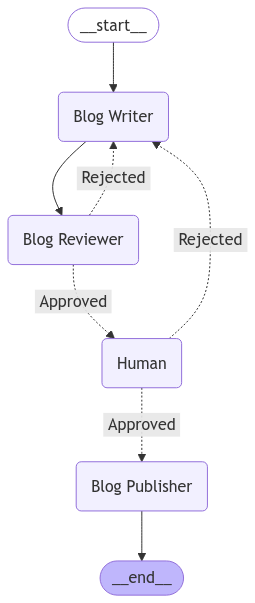

In [7]:
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display
from langgraph.checkpoint.memory import MemorySaver

blog_workflow=StateGraph(BlogGenerateState)

# define the nodes
blog_workflow.add_node('Blog Writer',blog_writer)
blog_workflow.add_node('Blog Reviewer',blog_reviewer)
blog_workflow.add_node('Human',human_feedback)
blog_workflow.add_node('Blog Publisher',blog_publisher)

# define the edges
blog_workflow.add_edge(START,'Blog Writer')
blog_workflow.add_edge('Blog Writer','Blog Reviewer')
blog_workflow.add_conditional_edges('Blog Reviewer',reviewer_approval,{'Approved':'Human','Rejected':'Blog Writer'})
blog_workflow.add_conditional_edges('Human',human_approval,{'Approved':'Blog Publisher','Rejected':'Blog Writer'})
blog_workflow.add_edge('Blog Publisher',END)

memory=MemorySaver()

blogger=blog_workflow.compile(checkpointer=memory)

# view
display(Image(blogger.get_graph().draw_mermaid_png()))


In [8]:
config={'configurable':{'thread_id':'1'}}

response=blogger.invoke(input={'topic':'Oracle'},config=config)
response

Blog Successfully Published!
Blog Information:
Author:Tamilselvan
Status:LIVE
URL:http://tamil-selvanprema.blogspot.com/2025/02/oracle_38.html


{'topic': 'Oracle',
 'content': "Title: Unveiling the Mysteries of the Oracle: A Journey Through Time\n\nIntroduction\nIn the realm of ancient mysteries and spiritual guidance, the Oracle stands out as a beacon of wisdom and prophecy, a revered figure whose pronouncements have shaped the course of history. From the ancient Greek oracles to modern-day interpretations, the concept of the Oracle is deeply embedded in human culture and continues to captivate the imagination. This blog post aims to explore the history, significance, and modern-day relevance of the Oracle.\n\nThe Ancient Oracle: A Historical Perspective\nThe most famous Oracle in history is that of Delphi, located in central Greece. This Oracle, known as the Pythia, was a priestess who was believed to deliver prophecies from Apollo, the god of light and knowledge. People from all over the ancient world would journey to Delphi to seek guidance on matters ranging from personal dilemmas to decisions affecting entire nations. Th